In [109]:
import os
from os.path import join
import nibabel as nib
from skimage.measure import label, regionprops
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import pandas as pd

https://www.mathworks.com/help/images/ref/regionprops.html 

In [110]:
def connected_component_analysis(seg, thr=0.5):
    #print(type(seg), seg.shape, seg.min(), seg.max())
    mask = seg.copy()
    mask[mask > thr] = 255
    mask[mask <= thr] = 0

    lbl = label(mask)
    blobs = regionprops(lbl)
    #raw_bbox_list = [b.bbox for b in blobs]
    #axis_major_length_list = [b.axis_major_length for b in blobs]

    return blobs

def cystregionprops(r):
    area = r.area
    major = round(r.axis_major_length, 3)
    
    try:
        minor = round(math.sqrt(10 * (-r.inertia_tensor_eigvals[0] + r.inertia_tensor_eigvals[1] + r.inertia_tensor_eigvals[2])), 3)
    except ValueError:
        minor = np.nan

    return (area, major, minor)


In [111]:
# Folder path
seg_folder_path = '/data/ayc9699/dataset/pancreas_ipmn_ilkin/temporary_folder_cyst_segmentations/nyu/reoriented_renamed'
mri_folder_path = '/data/ayc9699/dataset/pancreas_ipmn/nyu/reoriented'

# List to store file paths

mri_file_paths = []
seg_file_paths = []
# Iterate over files in the folder
for root, dirs, files in os.walk(seg_folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        seg_file_paths.append(file_path)

# Print the file paths
for path in seg_file_paths:
    id = path.split("/")[-1].split("_")[1].split(".")[0]
    #print(id)
    mri_file_paths.append(os.path.join(mri_folder_path, f"nyu_{id}.nii.gz"))


In [112]:
for i in range(len(seg_file_paths)):
    print(f"pair {i+1}")
    print(seg_file_paths[i-1], "\n", mri_file_paths[i-1])

#print(len(seg_file_paths), len(mri_file_paths))

pair 1
/data/ayc9699/dataset/pancreas_ipmn_ilkin/temporary_folder_cyst_segmentations/nyu/reoriented_renamed/segmentation_0108.nii.gz 
 /data/ayc9699/dataset/pancreas_ipmn/nyu/reoriented/nyu_0108.nii.gz
pair 2
/data/ayc9699/dataset/pancreas_ipmn_ilkin/temporary_folder_cyst_segmentations/nyu/reoriented_renamed/segmentation_0020.nii.gz 
 /data/ayc9699/dataset/pancreas_ipmn/nyu/reoriented/nyu_0020.nii.gz
pair 3
/data/ayc9699/dataset/pancreas_ipmn_ilkin/temporary_folder_cyst_segmentations/nyu/reoriented_renamed/segmentation_0168.nii.gz 
 /data/ayc9699/dataset/pancreas_ipmn/nyu/reoriented/nyu_0168.nii.gz
pair 4
/data/ayc9699/dataset/pancreas_ipmn_ilkin/temporary_folder_cyst_segmentations/nyu/reoriented_renamed/segmentation_0133.nii.gz 
 /data/ayc9699/dataset/pancreas_ipmn/nyu/reoriented/nyu_0133.nii.gz
pair 5
/data/ayc9699/dataset/pancreas_ipmn_ilkin/temporary_folder_cyst_segmentations/nyu/reoriented_renamed/segmentation_0118.nii.gz 
 /data/ayc9699/dataset/pancreas_ipmn/nyu/reoriented/nyu_01

In [113]:

def create_df():
    column_names=['Center', 'Patient', 'Pancreas_volume_ml', 'Cyst_volume_ml', 'Panc_Cyst_volume_ml', 'Diagonal_mm', 'Panc_vol_to_Diagonal', 'Num_of_Cysts']
    # Add columns using a for loop

    # Define the number of cysts
    num_cysts = 3
    for i in range(num_cysts):
        area_column_name = f'Cyst_{i+1}_vol_ml'
        major_column_name = f'Cyst_{i+1}_major_mm'
        minor_column_name = f'Cyst_{i+1}_minor_mm'
        column_names.append(area_column_name)
        column_names.append(major_column_name)
        column_names.append(minor_column_name)

    # Create an empty DataFrame
    df = pd.DataFrame(columns = column_names)

    df.head()
    return df

In [114]:

def largest3rs(r_list, voxel_sizes):

    voxel_sizes = [voxel_sizes[2], voxel_sizes[1], voxel_sizes[0]]
    sorted_r = sorted(r_list, key=lambda r: r.axis_major_length, reverse=True)
    top_3 = []
    
    for r in sorted_r[:3]:
      
        cov_matrix = r.inertia_tensor

        # Perform eigendecomposition to obtain eigenvectors and eigenvalues
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Determine the dimension along which the major and minor axes lie
        major_axis_dimension = np.argmax(eigenvalues)
        minor_axis_dimension = np.argmin(eigenvalues)

        # Multiply the measurements by the corresponding voxel sizes
        axis_major_length_mm = r.major_axis_length * voxel_sizes[major_axis_dimension]
        try:
            axis_minor_length_mm = r.minor_axis_length * voxel_sizes[minor_axis_dimension]
        except ValueError:
            axis_minor_length_mm = np.nan
        
        # Use the calculated measurements and axis dimensions as needed
        #print(f"Axis Major Length (mm): {axis_major_length_mm}, Dimension: {major_axis_dimension}")
        #print(f"Axis Minor Length (mm): {axis_minor_length_mm}, Dimension: {minor_axis_dimension}")

        vol_ml = r.area * voxel_sizes[0] * voxel_sizes[1] * voxel_sizes[2]/1000

        #major = round(r.axis_major_length, 3)
        
        axis_major_length_mm = round(axis_major_length_mm, 3)
        axis_minor_length_mm = round(axis_minor_length_mm, 3)
        
        '''
        try:
            minor = round(math.sqrt(10 * (-r.inertia_tensor_eigvals[0] + r.inertia_tensor_eigvals[1] + r.inertia_tensor_eigvals[2])), 3)
        except ValueError:
            minor = np.nan
        '''        
        
        top_3.append((vol_ml, axis_major_length_mm, axis_minor_length_mm))
        #top_3.append((vol_ml, major, minor))

    
    return top_3


In [115]:
'''from skimage.measure import label, regionprops
import numpy as np
def compute_diagonal_length_3D(image, voxel_size_x, voxel_size_y, voxel_size_z):
    # Ensure that image is a binary image
    assert np.array_equal(image, image.astype(bool)), "Input should be a binary image"

    # Label the image
    labeled_image = label(image)

    # Compute the properties of the labeled regions
    regions = regionprops(labeled_image)

    # Initialize list to store diagonal lengths
    diagonals = []
    print("voxel",voxel_size_x, voxel_size_y, voxel_size_z)
    for region in regions:
        # Get the bounding box coordinates
        minp, minr, minc, maxp, maxr, maxc = region.bbox
        # Compute the width, height, and depth of the box
        width = (maxc - minc) * voxel_size_x
        height = (maxr - minr) * voxel_size_y
        depth = (maxp - minp) * voxel_size_z
        print("debug--------", "depth:", (maxc - minc), "y ekseni:", (maxr - minr),  "x ekseni:", (maxp - minp))
        print(region.bbox, width, height, depth)

        # Use Pythagorean theorem to compute the diagonal length
        diagonal = np.sqrt(width**2 + height**2 + depth**2)
        diagonals.append(diagonal)

    return diagonals'''

'from skimage.measure import label, regionprops\nimport numpy as np\ndef compute_diagonal_length_3D(image, voxel_size_x, voxel_size_y, voxel_size_z):\n    # Ensure that image is a binary image\n    assert np.array_equal(image, image.astype(bool)), "Input should be a binary image"\n\n    # Label the image\n    labeled_image = label(image)\n\n    # Compute the properties of the labeled regions\n    regions = regionprops(labeled_image)\n\n    # Initialize list to store diagonal lengths\n    diagonals = []\n    print("voxel",voxel_size_x, voxel_size_y, voxel_size_z)\n    for region in regions:\n        # Get the bounding box coordinates\n        minp, minr, minc, maxp, maxr, maxc = region.bbox\n        # Compute the width, height, and depth of the box\n        width = (maxc - minc) * voxel_size_x\n        height = (maxr - minr) * voxel_size_y\n        depth = (maxp - minp) * voxel_size_z\n        print("debug--------", "depth:", (maxc - minc), "y ekseni:", (maxr - minr),  "x ekseni:", (max

In [116]:
from skimage.measure import label, regionprops
import numpy as np
def compute_diagonal_length_3D(image, voxel_size_x, voxel_size_y, voxel_size_z):
    # Ensure that image is a binary image
    #print(image.shape)
    assert np.array_equal(image, image.astype(bool)), "Input should be a binary image"

    # Label the image
    labeled_image = label(image)
    #print(np.unique(labeled_image))

    # Compute the properties of the labeled regions
    regions = regionprops(labeled_image)

    # Initialize list to store diagonal lengths
    diagonals = []
    #print("voxel",voxel_size_x, voxel_size_y, voxel_size_z)
    for region in regions:
        # Get the bounding box coordinates
        minp, minr, minc, maxp, maxr, maxc = region.bbox
        # Compute the width, height, and depth of the box
        width = (maxp - minp) * voxel_size_x
        height = (maxr - minr) * voxel_size_y
        depth = (maxc - minc) * voxel_size_z
        #print("debug--------", "depth:", (maxc - minc), "y ekseni:", (maxr - minr),  "x ekseni:", (maxp - minp))
        #print(region.bbox, width, height, depth)

        # Use Pythagorean theorem to compute the diagonal length
        diagonal = np.sqrt(width**2 + height**2 + depth**2)
        diagonals.append(diagonal)

    return diagonals

In [117]:
'''
def largest3rs(r_list):
    sorted_r = sorted(r_list, key=lambda r: r.axis_major_length, reverse=True)
    top_3 = []
    
    for r in sorted_r[:3]:
        area = r.area
        major = round(r.axis_major_length, 3)
        
        try:
            minor = round(math.sqrt(10 * (-r.inertia_tensor_eigvals[0] + r.inertia_tensor_eigvals[1] + r.inertia_tensor_eigvals[2])), 3)
        except ValueError:
            minor = np.nan
        
        top_3.append((area, major, minor))
    
    return top_3
    '''

'\ndef largest3rs(r_list):\n    sorted_r = sorted(r_list, key=lambda r: r.axis_major_length, reverse=True)\n    top_3 = []\n    \n    for r in sorted_r[:3]:\n        area = r.area\n        major = round(r.axis_major_length, 3)\n        \n        try:\n            minor = round(math.sqrt(10 * (-r.inertia_tensor_eigvals[0] + r.inertia_tensor_eigvals[1] + r.inertia_tensor_eigvals[2])), 3)\n        except ValueError:\n            minor = np.nan\n        \n        top_3.append((area, major, minor))\n    \n    return top_3\n    '

In [133]:
#fig, axs = plt.subplots(1, 3, figsize=(15, 5))
from scipy.ndimage import zoom

df = create_df()

for eachpatientind in range(len(seg_file_paths)):
    pt_name = seg_file_paths[eachpatientind].split("/")[-1].split("_")[1].split(".")[0]
    print(pt_name)
    if seg_file_paths[eachpatientind].split("/")[-1].split("_")[-1] == 'pass.nii': continue
    #if pt_name == '0089': continue
    # Read niftii image and segmentation
    #print(pt_name)
    #img_nib = nib.load(mri_file_paths[eachpatientind])
    seg_nib = nib.load(seg_file_paths[eachpatientind])
    
    #print(pt_name, img_nib.header.get_zooms(), seg_nib.header.get_zooms())
    #print(pt_name, img_nib.shape, seg_nib.shape)

    if pt_name in ['0140', '0159', '0172']:
        print(seg_file_paths[eachpatientind].split("/")[-1])
        #print(pt_name, img_nib.header.get_zooms(), seg_nib.header.get_zooms())
    #else:
        #assert img_nib.header.get_zooms() == seg_nib.header.get_zooms()
    #assert img_nib.shape == seg_nib.shape

    #zx, zy, zz = img_nib.header.get_zooms()
    voxel_sizes = seg_nib.header.get_zooms()
    print(voxel_sizes)

    seg = seg_nib.get_fdata()
    print(np.unique(seg))

    '''    
    current_zooms = seg_nib.header.get_zooms()
    scaling_factors = (1 / current_zooms[0], 1 / current_zooms[1], 1 / current_zooms[2])
    seg_data = seg_nib.get_fdata()
    rescaled_image_data = zoom(seg_data, scaling_factors, order=1)  # Use order=1 for bilinear interpolation
    new_header = seg_nib.header.copy()
    new_header.set_zooms((1, 1, 1))
    rescaled_seg_nib = nib.Nifti1Image(rescaled_image_data, seg_nib.affine, header=new_header)
    seg = rescaled_seg_nib.get_fdata()
    '''
    
    #print('img', img.shape)
    #print('seg', seg.shape)

    cysts = (seg == 5)
    pancreas = (seg == 1)
    
    labels = sorted(np.unique(seg))
    print("ll",labels)
    if len(labels)==2:
        panc_label = labels[1]
        pancreas = (seg == panc_label)
        cysts = (seg == 9999)

        
    cysts_b = cysts.astype(int)
    pancreas_b = pancreas.astype(int)
    pancreasandcyst = np.concatenate((cysts_b, pancreas_b))
    #print(np.unique(pancreasandcyst))

    # Find Bboxes
    blobs = connected_component_analysis(cysts, thr=0.5)
    num_of_cysts = len(blobs)

    # Calculate the voxel volume (assuming isotropic voxel size)
    voxel_vol_mm3 = voxel_sizes[0] *voxel_sizes[1] * voxel_sizes[2]  # Specify the voxel volume in your desired units

    # Calculate the volume of the segmentation mask
    cysts_volume_mm3 = np.sum(cysts != 0) * voxel_vol_mm3
    cysts_volume_ml = cysts_volume_mm3 / 1000

    pancreas_volume_mm3= np.sum(pancreas != 0) * voxel_vol_mm3
    pancreas_volume_ml= pancreas_volume_mm3 / 1000

    diagonal_lenght = max(compute_diagonal_length_3D(pancreasandcyst, voxel_sizes[0], voxel_sizes[1], voxel_sizes[2]))
    #diagonal_lenght = max(compute_diagonal_length_3D(pancreasandcyst, voxel_sizes[0], voxel_sizes[1], voxel_sizes[2]))

    #print(max(diagonal_lenght))
    pancreas_volume_to_diagonal = pancreas_volume_ml / diagonal_lenght
    #print(pancreas_volume_to_diagonal)
    column_data = ['NYU', pt_name, pancreas_volume_ml, cysts_volume_ml, pancreas_volume_ml + cysts_volume_ml, diagonal_lenght, pancreas_volume_to_diagonal, num_of_cysts]

    result = largest3rs(blobs, voxel_sizes)
    # Print the result
    for i, props in enumerate(result, start=1):
        #print(f"Top {i}: Area={props[0]}, Major={props[1]}, Minor={props[2]}")
        area, major, minor = props[0], props[1], props[2]
        column_data.append(area)
        column_data.append(major)
        column_data.append(minor)

    #print(column_data)
    column_data.extend([math.nan] * (17 - len(column_data)))
    #print(column_data)

    df.loc[len(df)] = column_data

df.head()

#plt.show()

0020
(0.9375, 0.9375, 6.0)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0168
(1.5625, 1.5625, 4.00012)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0133
(0.8594, 0.8594, 4.4000015)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0118
(0.78125, 0.78125, 4.0)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0099
(1.2695312, 1.2695312, 4.4)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0173
(1.5625, 1.5625, 4.0)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0026
(1.3671875, 1.3671875, 4.4)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0026
0063
(1.09375, 1.09375, 6.0)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0047
(1.4648438, 1.4648438, 4.4)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0127
(1.4648438, 1.4648438, 4.4)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0128
(1.3671875, 1.3671875, 4.0)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0132
(1.015625, 1.015625, 4.0)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0159
segmentation_0159.nii.gz
(1.3671875, 1.3671875, 4.4)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0094
(1.484375, 1.484375, 4.0)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0157
(1.2695312, 1.2695312, 4.4)
[0. 1. 5.]
ll [0.0, 1.0, 5.0]
0025
(1.09375, 1.09375, 5.999989)
[0. 1. 5.]
ll [0.

,Center,Patient,Pancreas_volume_ml,Cyst_volume_ml,Panc_Cyst_volume_ml,Diagonal_mm,Panc_vol_to_Diagonal,Num_of_Cysts,Cyst_1_vol_ml,Cyst_1_major_mm,Cyst_1_minor_mm,Cyst_2_vol_ml,Cyst_2_major_mm,Cyst_2_minor_mm,Cyst_3_vol_ml,Cyst_3_major_mm,Cyst_3_minor_mm
0,NYU,0020,97.764258,13.383984,111.148242,208.048466,0.469911,10,12.498047,33.445,31.616,0.137109,12.912,0.000,0.290039,9.963,NaN
1,NYU,0168,64.943360,30.059498,95.002857,199.563628,0.325427,9,28.809459,56.277,43.192,0.400403,15.445,NaN,0.097659,10.825,0.000
2,NYU,0133,71.207464,0.997658,72.205123,187.254020,0.380272,1,0.997658,15.389,9.648,NaN,NaN,NaN,NaN,NaN,NaN
3,NYU,0118,31.687012,8.073730,39.760742,170.979488,0.185326,33,2.832031,105.630,26.372,4.428711,44.700,35.416,0.063477,8.588,4.383
4,NYU,0099,45.633945,0.156013,45.789959,160.418620,0.284468,19,0.028366,4.917,0.000,0.007092,0.000,0.000,0.007092,0.000,0.000


In [134]:
# Save the DataFrame to a CSV file
df.to_csv('server_cyst_segmentation_nyu.csv', index=False)

In [120]:
# Read the CSV file
add_info_df = pd.read_csv('NYU_pancreas_segmentation_FullVersion.csv')

add_info_df['Patient#'] = add_info_df['Patient#'].str.replace('Patient_', '')

add_info_df = add_info_df[add_info_df.label >= 0 ] #141 samples with labels
#add_info_df = add_info_df[add_info_df.Accuracy == 'accurate']

#(0 -> NRML, 1 -> LGD, 2 -> HGD, -1 -> missing label)
add_info_df = add_info_df.drop(['AC#','Case#', 'Volume(ml)', 'Diagonal(mm)', 'Ratio(V/D)', 'Accuracy', 'BMI', 'dob', 'date_modality', 'Note'], axis=1)

# Display the first few rows using .head()
add_info_df.head()



,Patient#,label,Age,Gender,CP,DM
0,0001,0.0,59.0,1.0,N,N
1,0002,0.0,66.0,1.0,N,N
2,0003,0.0,39.0,1.0,N,N
3,0004,1.0,77.0,1.0,N,N
5,0006,1.0,50.0,0.0,N,N


In [121]:
# Read the CSV file
duct_info_df = pd.read_csv('duct_measurements.csv')

duct_info_df = duct_info_df[duct_info_df['Center'] == 'NYU']

# Replace the 'patient' column values with required format
duct_info_df['Patient'] = duct_info_df['Patient'].str.replace('patient_', '')  # remove 'patient_'
duct_info_df['Patient'] = duct_info_df['Patient'].str.replace('.nii', '')  # remove '.nii'
duct_info_df['Patient'] = duct_info_df['Patient'].apply(lambda x: f'{int(x):04d}')  # ensure 4 digits

duct_info_df = duct_info_df.rename(columns={'Maximum diameter (mm)': 'Duct_max_mm', 'Location of maximum': 'Loc_max',
                        'Minimum diameter (mm)': 'Duct_min_mm', 'Location of minimum': 'Loc_min'})


# Create a dictionary mapping current values to new values
replacement_dict = {'head': 1, 'tail': 2, 'body': 3}

# Replace the values
duct_info_df['Loc_max'] = duct_info_df['Loc_max'].replace(replacement_dict)
duct_info_df['Loc_min'] = duct_info_df['Loc_min'].replace(replacement_dict)

duct_info_df = duct_info_df.drop(['Center'], axis=1)
                                
# Display the first few rows using .head()
duct_info_df.head()

/tmp/ipykernel_176890/1877886982.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  duct_info_df['Patient'] = duct_info_df['Patient'].str.replace('.nii', '')  # remove '.nii'


,Patient,Duct_max_mm,Loc_max,Duct_min_mm,Loc_min
0,0045,2.854,1,1.307,2
1,0038,2.331,1,1.539,3
2,0125,2.698,1,1.129,2
3,0127,2.815,1,1.681,1
4,0132,1.927,1,1.256,2


In [122]:
# Merge the DataFrames based on the common column
merged_df = pd.merge(df, duct_info_df, left_on='Patient', right_on='Patient')
merged_df = pd.merge(merged_df, add_info_df, left_on='Patient', right_on='Patient#')

import pandas as pd

pd.set_option('display.max_columns', None)

merged_df = merged_df.drop(['Patient#'], axis=1)

merged_df['label'] = merged_df.pop('label')

print(merged_df['label'].value_counts())

# Display the merged DataFrame
merged_df.head()

1.0    44
0.0    19
2.0    15
Name: label, dtype: int64


,Center,Patient,Pancreas_volume_ml,Cyst_volume_ml,Panc_Cyst_volume_ml,Diagonal_mm,Panc_vol_to_Diagonal,Num_of_Cysts,Cyst_1_vol_ml,Cyst_1_major_mm,Cyst_1_minor_mm,Cyst_2_vol_ml,Cyst_2_major_mm,Cyst_2_minor_mm,Cyst_3_vol_ml,Cyst_3_major_mm,Cyst_3_minor_mm,Duct_max_mm,Loc_max,Duct_min_mm,Loc_min,Age,Gender,CP,DM,label
0,NYU,0020,97.764258,0.0,97.764258,208.048466,0.469911,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.117,3,1.090,3,56.0,1.0,N,N,1.0
1,NYU,0168,64.943360,0.0,64.943360,199.563628,0.325427,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.717,3,2.535,2,55.0,0.0,Y,N,2.0
2,NYU,0133,71.207464,0.0,71.207464,187.254020,0.380272,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.022,1,1.904,3,77.0,0.0,N,N,1.0
3,NYU,0118,31.687012,0.0,31.687012,170.979488,0.185326,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.187,1,2.334,2,77.0,0.0,N,Y,1.0
4,NYU,0099,45.633945,0.0,45.633945,160.418620,0.284468,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.029,3,1.309,2,53.0,1.0,N,N,1.0


In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.regressionplots import plot_partregress_grid

In [124]:
column = "Panc_vol_to_Diagonal"

def boxplot(column):
    #VOLUME
    ax = sns.boxplot(x='label', y=column, data=merged_df, palette="Set2") 
    ax.set_xticks([0, 1, 2])  # Set the tick locations
    ax.set_xticklabels(['NRML', 'LGD', 'HGD'])  # Set the tick labels


    plt.rc("figure", figsize=(6,5))
    plt.title(f'{column} of patient classification') 
    plt.xlabel('classification')
    plt.show()
    accu_mean =merged_df[column].mean()
    accu_std = merged_df[column].std()
    accu_mean1 = merged_df[column][merged_df.label == 0].mean()#NRML 
    accu_std1 =merged_df[column][merged_df.label == 0].std() 
    accu_mean2 = merged_df[column][merged_df.label == 1].mean() #LGD 
    accu_std2 = merged_df[column][merged_df.label == 1].std() 
    accu_mean3 = merged_df[column][merged_df.label == 2].mean() #HGD 
    accu_std3 = merged_df[column][merged_df.label == 2].std()

    #NRML vs. HGD vs. LGD: one-way ANOVA
    model1 = ols(f'{column} ~ C(label)', data=merged_df).fit() 
    anova_table1 = sm.stats.anova_lm(model1, typ=2)
    print(anova_table1)

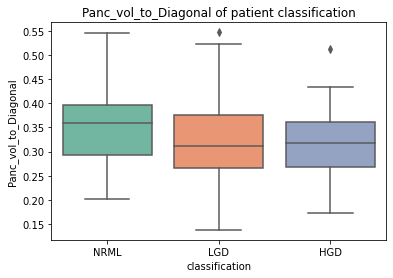

            sum_sq    df         F  PR(>F)
C(label)  0.018010   2.0  0.955898  0.3891
Residual  0.706521  75.0       NaN     NaN


In [125]:
column = "Panc_vol_to_Diagonal"
boxplot(column)

In [126]:
#3 T-tests pair-wise:
volume_0 = merged_df.loc[merged_df['label'] == 0, column].to_numpy() #NRML 
volume_1 = merged_df.loc[merged_df['label'] == 1, column].to_numpy() #LGD 
volume_2 = merged_df.loc[merged_df['label'] == 2, column].to_numpy() #HGD
print('Volume, NRML vs. LGD:') 
st.ttest_ind(a=volume_0, b=volume_1)

Volume, NRML vs. LGD:


Ttest_indResult(statistic=1.2724335256947255, pvalue=0.2080480895604962)

In [23]:
print('Volume, NRML vs. HGD:')
st.ttest_ind(a=volume_0, b=volume_2)

Volume, NRML vs. HGD:


Ttest_indResult(statistic=-0.3152214471569972, pvalue=0.7569363021461606)

In [24]:
# LGD vs. HGD
print('Volume, LGD vs. HGD:') 
st.ttest_ind(a=volume_1, b=volume_2)

Volume, LGD vs. HGD:


Ttest_indResult(statistic=-1.3729031198040336, pvalue=0.17556374997004898)

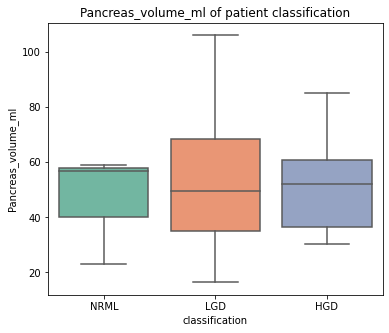

                sum_sq    df         F    PR(>F)
C(label)     98.533143   2.0  0.108754  0.897144
Residual  24915.600142  55.0       NaN       NaN


In [26]:
column = "Pancreas_volume_ml"
boxplot(column)

In [31]:
#3 T-tests pair-wise:
volume_0 = merged_df.loc[merged_df['label'] == 0, column].to_numpy() #NRML 
volume_1 = merged_df.loc[merged_df['label'] == 1, column].to_numpy() #LGD 
volume_2 = merged_df.loc[merged_df['label'] == 2, column].to_numpy() #HGD
print('Volume, NRML vs. LGD:') 
st.ttest_ind(a=volume_0, b=volume_1)

Volume, NRML vs. LGD:


Ttest_indResult(statistic=-0.43932562763098715, pvalue=0.6626777489055697)

In [32]:
print('Volume, NRML vs. HGD:')
st.ttest_ind(a=volume_0, b=volume_2)

Volume, NRML vs. HGD:


Ttest_indResult(statistic=-0.5072780563062289, pvalue=0.6193359679350012)

In [33]:
# LGD vs. HGD
print('Volume, LGD vs. HGD:') 
st.ttest_ind(a=volume_1, b=volume_2)

Volume, LGD vs. HGD:


Ttest_indResult(statistic=0.07201523188889224, pvalue=0.9428608650103196)

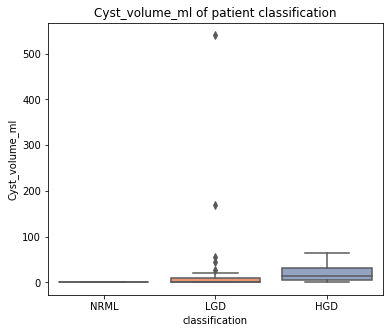

                 sum_sq    df         F    PR(>F)
C(label)    1572.935612   2.0  0.139975  0.869689
Residual  309025.102687  55.0       NaN       NaN


In [34]:
column = "Cyst_volume_ml"
boxplot(column)

In [35]:
#3 T-tests pair-wise:
volume_0 = merged_df.loc[merged_df['label'] == 0, column].to_numpy() #NRML 
volume_1 = merged_df.loc[merged_df['label'] == 1, column].to_numpy() #LGD 
volume_2 = merged_df.loc[merged_df['label'] == 2, column].to_numpy() #HGD
print('Volume, NRML vs. LGD:') 
st.ttest_ind(a=volume_0, b=volume_1)

Volume, NRML vs. LGD:


Ttest_indResult(statistic=-0.4590022443861051, pvalue=0.6485992848366657)

In [36]:
print('Volume, NRML vs. HGD:')
st.ttest_ind(a=volume_0, b=volume_2)

Volume, NRML vs. HGD:


Ttest_indResult(statistic=-1.747242806091206, pvalue=0.10103064641471957)

In [37]:
# LGD vs. HGD
print('Volume, LGD vs. HGD:') 
st.ttest_ind(a=volume_1, b=volume_2)

Volume, LGD vs. HGD:


Ttest_indResult(statistic=0.1558198544837075, pvalue=0.8767669995997894)

In [38]:
model = ols(formula='Panc_vol_to_Diagonal ~ 1 + C(label) + Age + C(Gender)+C(CP)+C(DM)', data = merged_df)
fitted1 = model.fit()
print(fitted1.summary())
aov_table = sm.stats.anova_lm(fitted1, typ=2)
print(aov_table)

                             OLS Regression Results                             
Dep. Variable:     Panc_vol_to_Diagonal   R-squared:                       0.185
Model:                              OLS   Adj. R-squared:                  0.089
Method:                   Least Squares   F-statistic:                     1.924
Date:                  Tue, 11 Jul 2023   Prob (F-statistic):             0.0947
Time:                          11:35:12   Log-Likelihood:                 108.55
No. Observations:                    58   AIC:                            -203.1
Df Residuals:                        51   BIC:                            -188.7
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           

In [45]:
'''columns_of_interest = ['Pancreas volume (ml)', 'Cyst volume (ml)', 'Panc + Cyst volume (ml)',
                       'Cyst_1_area (mm3)', 'Cyst_1_major (mm)', 'Cyst_1_minor (mm)',
                       'Cyst_2_area (mm3)', 'Cyst_2_major (mm)', 'Cyst_2_minor (mm)',
                       'Cyst_3_area (mm3)', 'Cyst_3_major (mm)', 'Cyst_3_minor (mm)',
                       'Age', 'Gender', 'BMI', 'CP', 'DM']

# Calculate the correlation matrix
correlation_matrix = merged_df[columns_of_interest].corr()

# Display the correlation matrix
print(correlation_matrix)'''

                         Pancreas volume (ml)  Cyst volume (ml)  \
Pancreas volume (ml)                 1.000000          0.248965   
Cyst volume (ml)                     0.248965          1.000000   
Panc + Cyst volume (ml)              0.488925          0.966584   
Cyst_1_area (mm3)                    0.271299          0.998810   
Cyst_1_major (mm)                    0.082091          0.440864   
Cyst_1_minor (mm)                    0.434493          0.569131   
Cyst_2_area (mm3)                   -0.002524          0.237125   
Cyst_2_major (mm)                    0.053578          0.400992   
Cyst_2_minor (mm)                   -0.007998          0.025040   
Cyst_3_area (mm3)                   -0.028950          0.201986   
Cyst_3_major (mm)                    0.100436          0.110269   
Cyst_3_minor (mm)                    0.092344         -0.168873   
Age                                 -0.513615         -0.303659   
Gender                              -0.070306          0.15119

/tmp/ipykernel_16043/1336448874.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_df[columns_of_interest].corr()


In [14]:
'''BaseException'''


segmentation_0159.nii.gz
0159 (1.3671875, 1.3671875, 4.4000015) (1.3671875, 1.3671875, 4.4)
segmentation_0172.nii
0172 (1.5625, 1.5625, 4.399994) (1.5625, 1.5625, 4.4)
segmentation_0140.nii.gz
0140 (0.68359375, 0.68359375, 6.5000076) (0.68359375, 0.68359375, 6.5)


,Center,Patient,Pancreas volume (ml),Cyst volume (ml),Panc + Cyst volume (ml),Cyst_1_area,Cyst_1_major,Cyst_1_minor,Cyst_2_area,Cyst_2_major,Cyst_2_minor,Cyst_3_area,Cyst_3_major,Cyst_3_minor
0,NYU,0020,97.764258,13.383984,111.148242,12498.046875,35.674,5.269,137.109375,13.773,0.000,290.039062,10.627,NaN
1,NYU,0168,64.943360,30.059498,95.002857,28809.460258,36.017,10.798,400.402668,9.885,NaN,97.659187,6.928,0.000
2,NYU,0133,71.207464,0.997658,72.205123,997.658434,17.907,2.193,NaN,NaN,NaN,NaN,NaN,NaN
3,NYU,0118,31.687012,8.073730,39.760742,2832.031250,135.207,6.593,4428.710938,57.216,8.854,63.476562,10.992,1.096
4,NYU,0099,45.633945,0.156013,45.789959,28.366089,3.873,0.000,7.091522,0.000,0.000,7.091522,0.000,0.000


In [19]:
''#WITH EIGENVALUES

#fig, axs = plt.subplots(1, 3, figsize=(15, 5))

df = create_df()

for eachpatientind in range(len(seg_file_paths)):
    
    pt_name = seg_file_paths[eachpatientind].split("/")[-1].split("_")[1].split(".")[0]
    if seg_file_paths[eachpatientind].split("/")[-1].split("_")[-1] == 'pass.nii': continue
    if pt_name == '0089': continue
    # Read niftii image and segmentation
    #print(pt_name)
    img_nib = nib.load(mri_file_paths[eachpatientind])
    seg_nib = nib.load(seg_file_paths[eachpatientind])
    
    #print(pt_name, img_nib.header.get_zooms(), seg_nib.header.get_zooms())
    #print(pt_name, img_nib.shape, seg_nib.shape)

    if pt_name in ['0140', '0159', '0172']:
        print(seg_file_paths[eachpatientind].split("/")[-1])
        print(pt_name, img_nib.header.get_zooms(), seg_nib.header.get_zooms())
    else:
        assert img_nib.header.get_zooms() == seg_nib.header.get_zooms()
    assert img_nib.shape == seg_nib.shape

    zx, zy, zz = img_nib.header.get_zooms()
    voxel_sizes = img_nib.header.get_zooms()

    img = img_nib.get_fdata()
    seg = seg_nib.get_fdata()

    #print('img', img.shape)
    #print('seg', seg.shape)

    cysts = (seg == 5)
    pancreas = (seg == 1)

    # Find Bboxes
    blobs = connected_component_analysis(cysts, thr=0.5)
    #print("num of blobs", len(blobs))

    # Calculate the voxel volume (assuming isotropic voxel size)
    voxel_vol_mm3 = zx * zy* zz     #voxel_volume_mm3 = 1.0  # Specify the voxel volume in your desired units

    # Calculate the volume of the segmentation mask
    cysts_volume_mm3 = np.sum(cysts != 0) * voxel_vol_mm3
    cysts_volume_ml = cysts_volume_mm3 / 1000

    pancreas_volume_mm3= np.sum(pancreas != 0) * voxel_vol_mm3
    pancreas_volume_ml= pancreas_volume_mm3 / 1000

    column_data = ['NYU', pt_name, pancreas_volume_ml, cysts_volume_ml, pancreas_volume_ml + cysts_volume_ml]


    result = largest3rs(blobs, voxel_sizes)
    # Print the result
    for i, props in enumerate(result, start=1):
        #print(f"Top {i}: Area={props[0]}, Major={props[1]}, Minor={props[2]}")
        area, major, minor = props[0]*voxel_vol_mm3, props[1], props[2]
        column_data.append(area)
        column_data.append(major)
        column_data.append(minor)

    #print(column_data)
    column_data.extend([math.nan] * (14 - len(column_data)))
    #print(column_data)

    df.loc[len(df)] = column_data

df.head()

#plt.show()
''

segmentation_0159.nii.gz
0159 (1.3671875, 1.3671875, 4.4000015) (1.3671875, 1.3671875, 4.4)
segmentation_0172.nii
0172 (1.5625, 1.5625, 4.399994) (1.5625, 1.5625, 4.4)
segmentation_0140.nii.gz
0140 (0.68359375, 0.68359375, 6.5000076) (0.68359375, 0.68359375, 6.5)


,Center,Patient,Pancreas volume (ml),Cyst volume (ml),Panc + Cyst volume (ml),Cyst_1_area,Cyst_1_major,Cyst_1_minor,Cyst_2_area,Cyst_2_major,Cyst_2_minor,Cyst_3_area,Cyst_3_major,Cyst_3_minor
0,NYU,0020,97.764258,13.383984,111.148242,12498.046875,214.045,4.940,137.109375,82.636,0.000,290.039062,63.761,NaN
1,NYU,0168,64.943360,30.059498,95.002857,28809.460258,144.073,16.872,400.402668,39.541,NaN,97.659187,27.714,0.000
2,NYU,0133,71.207464,0.997658,72.205123,997.658434,78.789,1.884,NaN,NaN,NaN,NaN,NaN,NaN
3,NYU,0118,31.687012,8.073730,39.760742,2832.031250,540.827,5.151,4428.710938,228.863,6.917,63.476562,43.969,0.856
4,NYU,0099,45.633945,0.156013,45.789959,28.366089,17.041,0.000,7.091522,0.000,0.000,7.091522,0.000,0.000


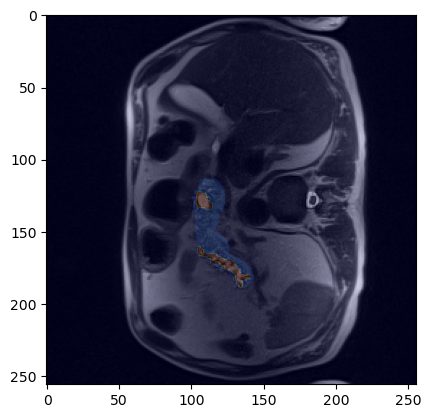

In [128]:
plt.imshow(img[:, :, 32], cmap='gray')
plt.imshow(seg[:, :, 32], cmap='jet', alpha=0.2)
plt.show()

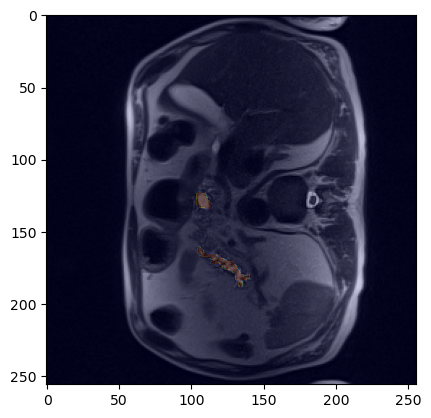

In [125]:

plt.imshow(img[:, :, 32], cmap='gray')
plt.imshow(cysts[:, :, 32], cmap='jet', alpha=0.2)
plt.show()

In [126]:
'''blobs = connected_component_analysis(cysts, thr=0.5)

i=0
for r in blobs:
    print(f"Box {i+1}", 
          "\nBounding box", r.bbox, 
          "\nArea", r.area, 
          "\nAxis major lenght", round(r.axis_major_length,3), 
          #"\nAxis minor lenght", round(r.axis_minor_length,3), 
          "\nCentroid", r.centroid,
          "\n-------------------------" )
    i += 1'''

img (256, 256, 63)
seg (256, 256, 63)
Box 1 
Bounding box (99, 98, 29, 194, 145, 46) 
Area 5148 
Axis major lenght 100.603 
Centroid (127.72183372183372, 115.11402486402487, 37.57167832167832) 
-------------------------
Box 2 
Bounding box (142, 104, 29, 143, 105, 30) 
Area 1 
Axis major lenght 0.0 
Centroid (142.0, 104.0, 29.0) 
-------------------------
Box 3 
Bounding box (146, 120, 31, 150, 124, 32) 
Area 12 
Axis major lenght 4.282 
Centroid (147.5, 121.5, 31.0) 
-------------------------


In [12]:
'''for bbox in bboxes:
    x1,y1,z1,x2,y2,z2 = bbox
    print(x1,y1,z1,x2,y2,z2)
    for z in range(z1, z2):
        slice = cysts[:,:,z].copy()
        slice = slice.astype(float)*255
        cv2.rectangle(slice, (x1, y1), (x2, y2), (255,0,0), 2)
        cv2.imwrite(join(r'C:\Users\pky0507\Desktop\ilkin\pancreas_ipmn\temporary_folder_cyst_segmentations\nyu\temp','{}.png'.format(z)), slice)'''



99 98 29 194 145 46
142 104 29 143 105 30
146 120 31 150 124 32


In [32]:
'''cysts_list = []
for slice in np.swapaxes(seg, 0, 2).tolist():
    slice_new = np.array(slice).copy().astype(float)#*255
    slice_new = np.concatenate((slice_new[:,:,None], slice_new[:,:,None], slice_new[:,:,None]), axis=2)
    #slice_new = cv2.cvtColor(slice_new, cv2.COLOR_GRAY2BGR)
    #print(slice_new.shape, slice_new.min(), slice_new.max())
    cysts_list.append(slice_new)

print(len(cysts_list))
#print(cysts_list.shape)
for bbox in bboxes:
    x1,y1,z1,x2,y2,z2 = bbox
    print(x1,y1,z1,x2,y2,z2)
    color1 = (list(np.random.choice(range(256), size=3)))  
    color =[int(color1[0]), int(color1[1]), int(color1[2])]
    for z in range(z1, z2):      
        cv2.rectangle(cysts_list[z], (x1, y1), (x2, y2), color, 2)


for i, slice in enumerate(cysts_list):
    cv2.imwrite(join(r'C:\Users\pky0507\Desktop\ilkin\pancreas_ipmn\temporary_folder_cyst_segmentations\nyu\temp','{}.png'.format(i)), slice)

for ml in axis_major_length_list:
    print(ml)
'''

63
99 98 29 194 145 46
142 104 29 143 105 30
146 120 31 150 124 32
100.60336055296284
0.0
4.281744192888377
